In [1]:
import features_extraction
import numpy as np
import glob
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

In [15]:
PRED_PATH=r'../data/results/result.npy'


In [16]:
sig_npy = np.load(PRED_PATH)
# [gt, pred, cond]
sig_npy.shape
ppg = sig_npy[2]

FileNotFoundError: [Errno 2] No such file or directory: '../data/results/result.npy'

In [6]:
ppg = np.load("../data/processed/BP_npy/PulseDB/train.npy")[:,1]
ppg.shape

(902160, 1250)

In [ ]:

fs = 125

In [ ]:
# heads_feats = []
# for i in trange(len(ppg)):
#     try:
#         feat = features_extraction.extract_feat_original(ppg[i], fs, filtered=True, remove_start_end=False)
#         feat[0].append("signal_index")
#         feat[1].append(i)
#         heads_feats.append(feat)
#     except Exception as e:
#         print(i,e)

  3%|▎         | 10429/312442 [01:16<37:09, 135.44it/s]


KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(columns=["fsignal"])
df

,fsignal


In [ ]:
df = pd.DataFrame(columns=["fsignal"])
for i in trange(len(ppg)):
    tmp = {"fsignal":[],"signal_index":[]}
    tmp["fsignal"].append(ppg[i])
    tmp["signal_index"].append(i)
    a = pd.DataFrame(tmp)
    df = pd.concat([df,a])
df = df.reset_index(drop=True)

100%|██████████| 111600/111600 [02:45<00:00, 674.91it/s]


In [ ]:
df = df.reset_index(drop=True)
df

,fsignal,signal_index
0,"[0.2932765855927233, 0.28963062834541314, 0.28...",0.0
1,"[0.7115393313576436, 0.7710721671318311, 0.824...",1.0
2,"[0.4409336923802916, 0.5009323340473307, 0.563...",2.0
3,"[0.5417142371831312, 0.5156276152273845, 0.492...",3.0
4,"[0.37640909304247827, 0.36357457539260685, 0.3...",4.0
...,...,...
111595,"[0.12788225913300047, 0.11542112175930701, 0.1...",111595.0
111596,"[0.13862173367298722, 0.1288473146757424, 0.11...",111596.0
111597,"[0.2975275374357114, 0.33964523836325505, 0.38...",111597.0
111598,"[0.36737396049276644, 0.4453093145343864, 0.52...",111598.0


In [ ]:
df = _extract_ppg_cycles(df)

NameError: name 'df' is not defined

In [ ]:
df.head()

,fsignal,signal_index,cs,pks_norm,ppg_f1,ppg_f2,ppg_pks,ppg_vlys
0,"[0.2932765855927233, 0.28963062834541314, 0.28...",0.0,"[[0.1568064754718356, 0.15744123025648188, 0.1...","[22, 21, 21, 32, 36, 42, 22, 22, 31, 23, 24, 22]",False,False,"[66, 162, 258, 354, 448, 547, 639, 733, 831, 9...","[44, 141, 237, 322, 412, 505, 617, 711, 800, 9..."
1,"[0.7115393313576436, 0.7710721671318311, 0.824...",1.0,"[[0.0031309894809954104, 0.0059815617105531535...","[24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 2...",False,False,"[83, 158, 234, 309, 384, 459, 534, 610, 685, 7...","[59, 134, 209, 284, 359, 434, 509, 585, 660, 7..."
2,"[0.4409336923802916, 0.5009323340473307, 0.563...",2.0,"[[0.12293136629291575, 0.12437059901601046, 0....","[20, 19, 17, 38, 21, 36, 18, 18, 20, 35, 19, 2...",False,False,"[91, 174, 255, 338, 419, 503, 584, 666, 748, 8...","[71, 155, 238, 300, 398, 467, 566, 648, 728, 7..."
3,"[0.5417142371831312, 0.5156276152273845, 0.492...",3.0,"[[0.1166958045139632, 0.11849120967631041, 0.1...","[33, 20, 22, 18, 19, 21, 20, 30, 20, 21, 19, 1...",False,False,"[70, 153, 236, 319, 402, 485, 568, 651, 733, 8...","[37, 133, 214, 301, 383, 464, 548, 621, 713, 7..."
4,"[0.37640909304247827, 0.36357457539260685, 0.3...",4.0,"[[0.06397951896726176, 0.06609683080256429, 0....","[19, 21, 21, 20, 32, 20, 21, 27, 18, 22, 20, 2...",False,False,"[64, 143, 220, 299, 378, 455, 534, 612, 690, 7...","[45, 122, 199, 279, 346, 435, 513, 585, 672, 7..."


# func

In [1]:
import features_extraction
import numpy as np
import glob
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
def _extract_ppg_cycles(df):
    """ Compute and save the ppg cycles in dataframe.
        This function updates filtered signal. 
    """
    def _extract_c(sig, fs, pk_th=0.6, remove_start_end=False):
        """ Wrapper for extract_cycle_check function. """
        try:
            cs, pks_norm, flag1, flag2, pks, vlys = features_extraction.extract_cycle_check(sig, fs, pk_th, remove_start_end)
        except:
            cs, pks_norm, flag1, flag2, pks, vlys = [], [], True, True, [], []
        return cs, pks_norm, flag1, flag2, pks, vlys

    c_ppg = Parallel(n_jobs=-1)(delayed(_extract_c)(sig, fs=125, remove_start_end=False) for sig in df.fsignal)

    for i, label in enumerate(['cs','pks_norm','ppg_f1','ppg_f2','ppg_pks','ppg_vlys']):
        df[label] = [val[i] for val in c_ppg]
    not_computed = ((df['ppg_pks'].map(len)==0) | (df['ppg_f2']))
    # cl_log.write(" - removed by not computed: {} \n".format((not_computed).sum()))
    df = df[~not_computed].reset_index(drop=True)

    return df
def _wrapper_compute_features_parallel(df, ver2=False):
    def process_row(row):
        try:
            mean = True
            fs=125
            feat_name, feats = features_extraction.extract_feat_cycle(
                row.cs, row.pks_norm, fs=fs, ver2=ver2,mean=mean
            )
            # print(len(feats),type(feats))
            # print(feats)
            if mean:
                feat_name = np.append(feat_name, "signal_index")
                feats = np.append(feats, row.signal_index)
                
            return feat_name, feats, False  # error=False
        except Exception as e:
            print(e)
            return None, None, True         # error=True

    results = [process_row(row) for _, row in df.iterrows()]

    error_count = sum(err for _, _, err in results)
    # print(f"Number of errors during feature extraction: {error_count}")

    heads_feats = [(h, f) for h, f, err in results if not err]
    return heads_feats

def zerocrossing(x):
    """Find zero crossing points in signal x (class版と同じ)"""
    inew = 0
    r = x
    loc = []
    for ch in range(1, len(r)):
        if ((r[ch-1] < 0 and r[ch] > 0) or
            (r[ch-1] > 0 and r[ch] < 0)):
            loc.append(ch)
            inew += 1
    return np.array(loc, dtype=int)

# test samples

In [3]:
# ppg = np.load("../data/processed/BP_npy/PulseDB/test_4.npy")[:,0]
ppg = np.load("../data/processed/BP_npy/PulseDB/test.npy",mmap_mode="r")[:,1]

In [12]:
i = np.random.randint(0, len(ppg)-1)
print(i)
target = ppg[i]

245788


In [4]:
i=0

In [ ]:
i=47671


In [6]:
target = ppg[i]

In [ ]:
for j in range(len(vlys)-1):
    plt.figure(figsize=(12,4))
    plt.plot( ppg[i][vlys[j]:vlys[j+1]])
    plt.plot(df.iloc[0].fsignal[vlys[j]:vlys[j+1]])

In [2]:
import scipy
ppg_chunk = ppg[i].reshape(1,-1)
df = pd.DataFrame(columns=["fsignal"])
for j in trange(len(ppg_chunk)):
    tmp = {"fsignal":[],"signal_index":[]}
    tmp["fsignal"].append(ppg_chunk[j])
    tmp["signal_index"].append(i+j)
    a = pd.DataFrame(tmp)
    df = pd.concat([df,a])
df = df.reset_index(drop=True)
df = _extract_ppg_cycles(df)
print("extracted cycles:",len(df))
target = df.loc[0,'fsignal']
heads_feats = _wrapper_compute_features_parallel(df,ver2=True)
vlys = df.loc[0,'ppg_vlys']
jpg_min_prominence=50
jpg_distance=6
for j in range(len(vlys)-1):
    plt.figure(figsize=(16,2))
    plt.subplot(1,3,1)
    vpg = np.diff(target[vlys[j]:vlys[j+1]]) * 1000
    vpg = np.convolve(vpg, np.ones(6) / 6, mode='same')

    apg = np.diff(vpg) * 1000
    apg = np.convolve(apg, np.ones(8) / 8, mode='same')

    jpg = np.diff(apg) * 1000
    # class: rolling(window=85//8, center=True).mean()
    win = max(1, 85 // 8)
    # rolling meanの簡易版（端の扱いは完全一致しないが条件自体は同じように動く）
    jpg = np.diff(apg)*1000
    win = max(1, 85 // 8)
    jpg = np.convolve(jpg, np.ones(win) / win, mode="same")
    min_peaks, _ = scipy.signal.find_peaks(-jpg, prominence=jpg_min_prominence, distance=jpg_distance)
    peak = df["pks_norm"][0][j]
    w,y,z = features_extraction.vpg_points(vpg,peak)
    w2,y2,z2 = features_extraction.vpg_points2(vpg,peak)
    T2_5 = ((vlys[j+1]-vlys[j] - 4) / 100) * 2.5
    a,b,c,d,e = features_extraction.apg_points(apg, peak, w, y, z)
    a2, b2, c2, d2, e2 = features_extraction.apg_points2(apg, peak,w2,y2,z2,jpg=None,T2_5=T2_5,log=True)
    import numpy as np
    import matplotlib.pyplot as plt

    points = {
    "a": a, "b": b, "c": c, "d": d, "e": e,
    "a2": a2, "b2": b2, "c2": c2, "d2": d2, "e2": e2
    }
    points_jpg = {
    "c": c, "d": d, "e": e, "c2": c2, "d2": d2, "e2": e2
    }
    plt.plot(apg)
    ids = np.arange(len(points))  # 色割り当て用ID
    apg_maxima, _ = scipy.signal.find_peaks(apg, prominence=1.5, distance=7)
    plt.vlines(apg_maxima, ymin=np.min(apg), ymax=np.max(apg), colors='r', linestyles='dashed')
    plt.hlines(0, xmin=0, xmax=len(apg), colors='gray', linestyles='dashed')
    for label, idx in points.items(): # RGBランダム
        if idx is None:
            continue
        plt.scatter(
            idx,
            apg[idx],
            label=label,
            cmap="tab10",
            alpha=0.5,
            s=60
        )
        offset = (0,20) if label in ["a2", "b2", "c2", "d2", "e2"] else (0,10)
        plt.annotate(
            label,
            (idx, apg[idx]),
            textcoords="offset points",
            xytext=offset,
            ha='center',
            fontsize=8
        )

    plt.legend()
    plt.xlabel("Index")
    plt.ylabel("APG value")
    plt.title(f"APG")
    plt.subplot(1,3,2)
    plt.plot(jpg)
    plt.hlines(0, xmin=0, xmax=len(jpg), colors='gray', linestyles='dashed')
    for label, idx in points_jpg.items(): # RGBランダム
        if idx is None:
            continue
        plt.scatter(
            idx,
            jpg[idx],
            label=label,
            cmap="tab10",
            alpha=0.5,
            s=60
        )
        offset = (0,20) if label in ["a2", "b2", "c2", "d2", "e2"] else (0,10)
        plt.annotate(
            label,
            (idx, jpg[idx]),
            textcoords="offset points",
            xytext=offset,
            ha='center',
            fontsize=8
        )
    plt.legend(loc='upper right')
    plt.xlabel("Index")
    plt.ylabel("JPG value")
    plt.title(f"JPG")
    plt.subplot(1,3,3)
    spg = np.diff(jpg)
    plt.plot(spg)
    plt.hlines(0, xmin=0, xmax=len(spg), colors='gray', linestyles='dashed')
    # apg_minima, _ = scipy.signal.find_peaks(-apg, prominence=apg_prominence, distance=apg_distance)

    if len(apg_maxima) > 0:
        apg_max_idx = np.argmax(apg[apg_maxima])
        if apg_max_idx > 0:
            apg_maxima = apg_maxima[apg_max_idx:]
            # apg_minima = apg_minima[apg_minima >= apg_maxima[0]]

    z_jpg = zerocrossing(jpg)
    z_jpg = z_jpg[z_jpg >= int(apg_maxima[0]) - 2]

    z_spg = zerocrossing(spg)
    z_spg = z_spg[z_spg >= int(apg_maxima[0]) - 2]

    if len(z_jpg) >= 3:
        z_spg = z_spg[z_spg <= z_jpg[2] + 2]
    # else: classは print するだけ（処理は続行）

    spg_peaks, _ = scipy.signal.find_peaks(spg, prominence=40, distance=5)
    if len(spg_peaks) > 0 and spg_peaks[0] > apg_maxima[0]:
        spg_peaks = spg_peaks[1:]
    plt.vlines(spg_peaks, ymin=np.min(spg), ymax=np.max(spg), colors='r', linestyles='dashed')
    plt.title(f"SPG")

NameError: name 'ppg' is not defined

In [ ]:
df_a = pd.DataFrame(np.array(heads_feats[0][1]).transpose(),columns=heads_feats[0][0])
df_a

,Tc,Ts,Td,Tsteepest,Steepest,TNegSteepest,NegSteepest,TdiaRise,DiaRise,SteepDiaRise,TSystoDiaRise,TdiaToEnd,Ratio,Ts_norm,Td_norm,Tsteepest_norm,TNegSteepest_norm,TdiaRise_norm,TSystoDiaRise_norm,TdiaToEnd_norm,SW25,SW25_norm,DW25,DW25_norm,SWaddDW25,SWaddDW25_norm,DWdivSW25,SW50,SW50_norm,DW50,DW50_norm,SWaddDW50,SWaddDW50_norm,DWdivSW50,SW75,SW75_norm,DW75,DW75_norm,SWaddDW75,SWaddDW75_norm,DWdivSW75,S1,S2,S3,S4,AUCsys,AUCdia,S1_norm,S2_norm,S3_norm,S4_norm,AUCsys_norm,AUCdia_norm,SQI_skew,SQI_kurtosis,apg_a,apg_b,apg_c,apg_d,apg_e,ppg_a,ppg_b,ppg_c,ppg_d,ppg_e,ratio_apg_b,ratio_apg_c,ratio_apg_d,ratio_apg_e,ratio_ppg_b,ratio_ppg_c,ratio_ppg_d,ratio_ppg_e,T_a,T_b,T_c,T_d,T_e,T_a_norm,T_b_norm,T_c_norm,T_d_norm,T_e_norm,AI,bd,bcda,sdoo,cycle_zero
0,0.752,0.336,0.416,0.264,0.066349,0.408,-0.046641,0.640,0.094083,0.002268,0.304,0.112,9.455706,0.446809,0.553191,0.351064,0.542553,0.851064,0.404255,0.148936,0.104,0.138298,0.152,0.202128,0.256,0.340426,1.461538,0.072,0.095745,0.096,0.127660,0.168,0.223404,1.333333,0.048,0.063830,0.056,0.074468,0.104,0.138298,1.166667,3.479740,5.621008,12.171323,0.614064,9.100748,12.785387,0.382358,0.617642,0.951971,0.048029,0.415823,0.584177,1.188864,0.344992,0.008013,-0.010628,-0.003323,0.001185,0.002608,0.217039,0.889620,0.698045,0.512823,0.239660,-1.326422,-0.414681,0.147878,0.325507,4.098892,3.216214,2.362811,1.104225,0.208,0.112,0.056,0.032,0.064,0.276596,0.148936,0.074468,0.042553,0.085106,-1.385125,-0.004697,-1.059619,0.189490,0.084361
1,0.576,0.168,0.408,0.096,0.073925,0.248,-0.047471,0.472,0.052844,0.003936,0.304,0.104,17.810451,0.291667,0.708333,0.166667,0.430556,0.819444,0.527778,0.180556,0.104,0.180556,0.152,0.263889,0.256,0.444444,1.461538,0.072,0.125000,0.104,0.180556,0.176,0.305556,1.444444,0.048,0.083333,0.064,0.111111,0.112,0.194444,1.333333,1.696624,6.103113,13.588921,0.489344,7.799736,14.078265,0.217523,0.782477,0.965241,0.034759,0.356510,0.643490,0.720709,0.505657,0.008852,-0.011201,-0.003644,0.001295,0.002189,0.183462,0.941168,0.754898,0.518468,0.226353,-1.265487,-0.411706,0.146299,0.247253,5.130035,4.114730,2.826021,1.233786,0.040,0.112,0.056,0.040,0.064,0.069444,0.194444,0.097222,0.069444,0.111111,-1.247333,-0.004555,-1.000079,0.182400,0.027718
2,0.568,0.168,0.400,0.096,0.076813,0.240,-0.047022,0.456,0.051039,0.005547,0.288,0.112,18.666764,0.295775,0.704225,0.169014,0.422535,0.802817,0.507042,0.197183,0.096,0.169014,0.152,0.267606,0.248,0.436620,1.583333,0.072,0.126761,0.104,0.183099,0.176,0.309859,1.444444,0.048,0.084507,0.064,0.112676,0.112,0.197183,1.333333,1.587032,6.254893,13.701811,0.678254,7.841925,14.380064,0.202378,0.797622,0.952834,0.047166,0.352890,0.647110,0.689132,0.519348,0.009473,-0.011323,-0.001611,-0.002324,0.002889,0.121916,0.952727,0.068263,0.066778,0.048291,-1.195293,-0.170068,-0.245330,0.304966,7.814616,0.559921,0.547736,0.396100,0.032,0.120,0.320,0.016,-0.104,0.056338,0.211268,0.563380,0.028169,-0.183099,-1.084861,-0.000208,-0.779895,0.365721,0.000000
3,0.552,0.160,0.392,0.088,0.076232,0.240,-0.047186,0.448,0.048640,0.005202,0.288,0.104,19.445689,0.289855,0.710145,0.159420,0.434783,0.811594,0.521739,0.188406,0.096,0.173913,0.152,0.275362,0.248,0.449275,1.583333,0.072,0.130435,0.104,0.188406,0.176,0.318841,1.444444,0.048,0.086957,0.064,0.115942,0.112,0.202899,1.333333,1.404405,5.982607,13.148741,0.419541,7.387012,13.568282,0.190118,0.809882,0.969079,0.030921,0.352513,0.647487,0.665183,0.527961,0.009251,-0.011508,-0.001227,-0.002133,0.002948,0.164267,0.945838,0.061790,0.062893,0.045015,-1.243924,-0.132642,-0.230521,0.318655,5.757934,0.376153,0.382870,0.274033,0.032,0.112,0.312,0.016,-0.096,0.057971,0.202899,0.565217,0.028986,-0.173913,-1.199416,-0.000252,-0.880761,0.376132,0.015746
4,0.568,0.168,0.400,0.096,0.075145,0.240,-0.048601,0.456,0.046772,0.005985,0.288,0.112,20.000508,0.295775,0.704225,0.169014,0.422535,0.802817,0.507042,0.197183,0.096,0.169014,0.152,0.267606,0.248,0.436620,1.583333,0.072,0.126761,0.096,0.169014,0.168,0.295775,1.333333,0.048,0.084

In [ ]:
np.nanmean(df_a.values,axis=0)

array([ 7.39692308e-01,  3.21846154e-01,  4.17846154e-01,  2.36923077e-01,
        6.30585061e-02,  3.80923077e-01, -3.59479950e-02,  5.10153846e-01,
        2.83519705e-01, -2.23956969e-02,  1.88307692e-01,  2.29538462e-01,
        5.32763771e+00,  4.33230031e-01,  5.66769969e-01,  3.13946484e-01,
        5.14765773e-01,  6.89077175e-01,  2.55847144e-01,  3.10922825e-01,
        1.21230769e-01,  1.70373846e-01,  1.90153846e-01,  2.65936072e-01,
        3.11384615e-01,  4.36309918e-01,  1.56755548e+00,  8.73846154e-02,
        1.23022783e-01,  1.25538462e-01,  1.75065585e-01,  2.12923077e-01,
        2.98088368e-01,  1.43834499e+00,  5.60000000e-02,  7.86850277e-02,
        6.89230769e-02,  9.61369584e-02,  1.24923077e-01,  1.74821986e-01,
        1.23076923e+00,  2.08057157e+00,  6.88466226e+00,  1.22098627e+01,
        2.11809834e+00,  8.96523383e+00,  1.43279611e+01,  2.26992485e-01,
        7.73007515e-01,  8.54808482e-01,  1.45191518e-01,  3.81642098e-01,
        6.18357902e-01,  

In [ ]:
heads_feats = _wrapper_compute_features_parallel(df)
list_2 = []
for i,(h,f) in enumerate(heads_feats):
    if len(h)==0 or len(f) == 0:
        list_2.append(i)

list_series = [pd.Series(f, index=h, dtype='float64') for h,f in heads_feats]
res_second = pd.DataFrame(list_series)

88 <class 'list'>
[[0.76, 0.752, 0.784, 0.784, 0.464, 1.04, 0.752, 0.496, 0.752, 0.76, 0.76, 0.76, 0.752], [0.192, 0.192, 0.2, 0.2, 0.184, 0.48, 0.2, 0.2, 0.464, 0.472, 0.472, 0.472, 0.456], [0.568, 0.56, 0.584, 0.584, 0.28, 0.56, 0.552, 0.296, 0.288, 0.288, 0.288, 0.288, 0.296], [0.112, 0.112, 0.112, 0.112, 0.104, 0.4, 0.112, 0.112, 0.376, 0.384, 0.384, 0.384, 0.376], [0.04721157411851962, 0.04911831809397332, 0.04764443792787376, 0.04561487703511591, 0.06559234362972854, 0.07035334945225336, 0.06964343247465599, 0.06999314175452143, 0.06999660855835133, 0.069684090844776, 0.07183066865007293, 0.0707475103098284, 0.07233022580927273], [0.256, 0.256, 0.264, 0.264, 0.232, 0.544, 0.256, 0.248, 0.52, 0.536, 0.528, 0.528, 0.52], [-0.02794866837704235, -0.026976373803295983, -0.026527941221012208, -0.026766197184907803, -0.039161469958245765, -0.039798098142490246, -0.038983644774870596, -0.03751514368848641, -0.03919712577937673, -0.04059993488034308, -0.0410448574592408, -0.04262728075363

In [ ]:
# expand head
import pandas as pd

pd.set_option('display.max_columns', None)

res_second.head()

,Tc,Ts,Td,Tsteepest,Steepest,TNegSteepest,NegSteepest,TdiaRise,DiaRise,SteepDiaRise,TSystoDiaRise,TdiaToEnd,Ratio,Ts_norm,Td_norm,Tsteepest_norm,TNegSteepest_norm,TdiaRise_norm,TSystoDiaRise_norm,TdiaToEnd_norm,SW25,SW25_norm,DW25,DW25_norm,SWaddDW25,SWaddDW25_norm,DWdivSW25,SW50,SW50_norm,DW50,DW50_norm,SWaddDW50,SWaddDW50_norm,DWdivSW50,SW75,SW75_norm,DW75,DW75_norm,SWaddDW75,SWaddDW75_norm,DWdivSW75,S1,S2,S3,S4,AUCsys,AUCdia,S1_norm,S2_norm,S3_norm,S4_norm,AUCsys_norm,AUCdia_norm,SQI_skew,SQI_kurtosis,apg_a,apg_b,apg_c,apg_d,apg_e,ppg_a,ppg_b,ppg_c,ppg_d,ppg_e,ratio_apg_b,ratio_apg_c,ratio_apg_d,ratio_apg_e,ratio_ppg_b,ratio_ppg_c,ratio_ppg_d,ratio_ppg_e,T_a,T_b,T_c,T_d,T_e,T_a_norm,T_b_norm,T_c_norm,T_d_norm,T_e_norm,AI,bd,bcda,sdoo,cycle_zero
0,"(0.76, 0.752, 0.784, 0.784, 0.464, 1.04, 0.752...","(0.192, 0.192, 0.2, 0.2, 0.184, 0.48, 0.2, 0.2...","(0.568, 0.56, 0.584, 0.584, 0.28, 0.56, 0.552,...","(0.112, 0.112, 0.112, 0.112, 0.104, 0.4, 0.112...","(0.04721157411851962, 0.04911831809397332, 0.0...","(0.256, 0.256, 0.264, 0.264, 0.232, 0.544, 0.2...","(-0.02794866837704235, -0.026976373803295983, ...","(0.44, 0.44, 0.456, 0.456, 0.312, 0.728, 0.44,...","(0.1424633853416823, 0.14267077169458464, 0.14...","(-0.00954040917789517, -0.010999387825967932, ...","(0.248, 0.248, 0.256, 0.256, 0.128, 0.248, 0.2...","(0.32, 0.312, 0.328, 0.328, 0.152, 0.312, 0.31...","(5.301681221009295, 5.375303674418873, 5.36155...","(0.25263157894736843, 0.2553191489361702, 0.25...","(0.7473684210526316, 0.7446808510638298, 0.744...","(0.14736842105263157, 0.14893617021276595, 0.1...","(0.3368421052631579, 0.3404255319148936, 0.336...","(0.5789473684210527, 0.5851063829787234, 0.581...","(0.3263157894736842, 0.32978723404255317, 0.32...","(0.42105263157894735, 0.4148936170212766, 0.41...","(0.128, 0.128, 0.128, 0.136, 0.12, 0.112, 0.12...","(0.16842105263157894, 0.1702127659574468, 0.16...","(0.216, 0.216, 0.224, 0.208, 0.176, 0.184, 0.1...","(0.28421052631578947, 0.2872340425531915, 0.28...","(0.344, 0.344, 0.352, 0.344, 0.296, 0.296, 0.2...","(0.45263157894736844, 0.4574468085106383, 0.44...","(1.6875, 1.6875, 1.75, 1.5294117647058822, 1.4...","(0.088, 0.088, 0.088, 0.096, 0.088, 0.08, 0.08...","(0.11578947368421053, 0.11702127659574468, 0.1...","(0.136, 0.144, 0.144, 0.136, 0.112, 0.128, 0.1...","(0.17894736842105263, 0.19148936170212766, 0.1...","(0.224, 0.232, 0.232, 0.232, 0.2, 0.208, 0.208...","(0.29473684210526313, 0.30851063829787234, 0.2...","(1.5454545454545454, 1.6363636363636365, 1.636...","(0.056, 0.056, 0.056, 0.056, 0.056, 0.056, 0.0...","(0.07368421052631578, 0.07446808510638298, 0.0...","(0.072, 0.08, 0.08, 0.072, 0.064, 0.072, 0.064...","(0.09473684210526316, 0.10638297872340426, 0.1...","(0.128, 0.136, 0.136, 0.128, 0.12, 0.128, 0.12...","(0.16842105263157894, 0.18085106382978725, 0.1...","(1.2857142857142858, 1.4285714285714286, 1.428...","(1.2190062219040347, 1.260578402335542, 1.0375...","(4.7329073519136795, 4.859234043503991, 5.2385...","(10.412556887566815, 11.263276454178017, 11.30...","(0.6074056659053154, 0.6886678056109931, 1.596...","(5.9519135738177145, 6.119812445839534, 6.2760...","(11.01996255347213, 11.95194425978901, 12.8981...","(0.2048091268103095, 0.20598317570868171, 0.16...","(0.7951908731896905, 0.7940168242913181, 0.834...","(0.9448813312243121, 0.9423802696329551, 0.876...","(0.05511866877568801, 0.057619730367044916, 0....","(0.35069273008936025, 0.33863959910070535, 0.3...","(0.6493072699106397, 0.6613604008992947, 0.672...","(0.9140489379961233, 0.8577742772660703, 0.929...","(0.43308884775426004, 0.45381723499841525, 0.4...","(0.004715439094467921, 0.00508236335838258, 0....","(-0.0066620331847192515, -0.00689257024489931,...","(0.001112581389295375, 0.0009350907833252098, ...","(0.0002517157238829393, -9.418961017526595e-05...","(0.0017785010929946277, 0.0019470925584544607,...","(0.23803399610075715, 0.22691818156083293, 0.2...","(0.7502948119012072, 0.7607626480261092, 0.755...","(0.457500231093

In [ ]:
heads_feats_first = Parallel(n_jobs=-1)(delayed(features_extraction.extract_feat_original)(fsig, fs=fs, filtered = True, remove_start_end=False) for fsig in df['fsignal'])
list_2_1 = []
for i,(h,f) in enumerate(heads_feats_first):
    if len(h)==0 or len(f) == 0:
        list_2_1.append(i)
        

list_series = [pd.Series(f, index=h, dtype='float64') for h,f in heads_feats_first]
res = pd.DataFrame(list_series)

template = pd.read_csv("columns_template.csv")['columns'].values

f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
# cols = []
# for c in template:
#     if c in res.columns:
#         cols.append(c)

# res_first=res[cols].copy()

# data_feats = pd.concat([res_first,res_second], axis=1)
# data_feats = data_feats.drop(index=list_2+list_2_1).reset_index(drop=True)
# df = df.drop(index=list_2+list_2_1).reset_index(drop=True)
data_feats = res_second
keep_mask = ~data_feats.isna()['bd']

# data_feats = data_feats[keep_mask].reset_index(drop=True)
# df = df[keep_mask].reset_index(drop=True)

data_feats = data_feats.replace([np.inf, -np.inf], 0)
data_feats['signal_index']= data_feats['signal_index'].astype('int')


In [ ]:
data_feats.to_csv(r"../data/results/ppg_features_pulsedb_2class_train.csv")

### all

In [ ]:
ppg = np.load("../data/processed/BP_npy/PulseDB/test_4.npy")
ppg.shape

(111600, 1, 1250)

# run

In [2]:
import numpy as np

In [4]:
a  =np.load("../data/processed/BP_npy/PulseDB/test.npy", mmap_mode="r")

In [2]:
# ppg = np.load("../data/processed/BP_npy/PulseDB/train.npy",mmap_mode='r')[:,1]
ppg = np.load("../data/processed/BP_npy/PulseDB/test.npy",mmap_mode='r')[:,1]
length =1
fs=125
ver2=True
for i in range(0, len(ppg), length):
    # if i <190000:
    #     continue
    postfix = i//length
    print(i,postfix)
    ppg_chunk = ppg[i:i+length]
    df = pd.DataFrame(columns=["fsignal"])
    for j in trange(len(ppg_chunk)):
        tmp = {"fsignal":[],"signal_index":[]}
        tmp["fsignal"].append(ppg_chunk[j])
        tmp["signal_index"].append(i+j)
        a = pd.DataFrame(tmp)
        df = pd.concat([df,a])
    df = df.reset_index(drop=True)
    df = _extract_ppg_cycles(df)
    print("extracted cycles:",len(df))
    
    heads_feats = _wrapper_compute_features_parallel(df,ver2=ver2)
    # print(heads_feats)
    list_2 = []
    for k,(h,f) in enumerate(heads_feats):
        if len(h)==0 or len(f) == 0:
            list_2.append(k)
    # print(len(heads_feats[0][0]),len(heads_feats[0][1]))
    # print(heads_feats[0][0][-5:],heads_feats[0][1][-10:])
    list_series = [pd.Series(f, index=h, dtype='float64') for h,f in heads_feats]
    res_second = pd.DataFrame(list_series)
    heads_feats_first = Parallel(n_jobs=-1)(delayed(features_extraction.extract_feat_original)(fsig, fs=fs, filtered = True, remove_start_end=False) for fsig in df['fsignal'])
    list_2_1 = []
    for l,(h,f) in enumerate(heads_feats_first):
        if len(h)==0 or len(f) == 0:
            list_2_1.append(l)
            

    list_series = [pd.Series(f, index=h, dtype='float64') for h,f in heads_feats_first]
    res = pd.DataFrame(list_series)

    template = pd.read_csv("columns_template.csv")['columns'].values
    data_feats = res_second
    # keep_mask = ~data_feats.isna()['bd']

    # data_feats = data_feats[keep_mask].reset_index(drop=True)
    # df = df[keep_mask].reset_index(drop=True)

    data_feats = data_feats.replace([np.inf, -np.inf], 0)
    data_feats['signal_index']= data_feats['signal_index'].astype('int')
    print(data_feats.shape)
    data_feats.to_csv(f"../data/results/ppg_features_pulsedb_test6_{postfix}.csv")
# df = pd.DataFrame(columns=["fsignal"])
# for i in trange(len(ppg)):
#     tmp = {"fsignal":[],"signal_index":[]}
#     tmp["fsignal"].append(ppg[i])
#     tmp["signal_index"].append(i)
#     a = pd.DataFrame(tmp)
#     df = pd.concat([df,a])
# df = df.reset_index(drop=True)
# df = _extract_ppg_cycles(df)
# heads_feats = _wrapper_compute_features_parallel(df)
# list_2 = []
# for i,(h,f) in enumerate(heads_feats):
#     if len(h)==0 or len(f) == 0:
#         list_2.append(i)

# list_series = [pd.Series(f, index=h, dtype='float64') for h,f in heads_feats]
# res_second = pd.DataFrame(list_series)
# heads_feats_first = Parallel(n_jobs=-1)(delayed(features_extraction.extract_feat_original)(fsig, fs=fs, filtered = True, remove_start_end=False) for fsig in df['fsignal'])
# list_2_1 = []
# for i,(h,f) in enumerate(heads_feats_first):
#     if len(h)==0 or len(f) == 0:
#         list_2_1.append(i)
        

# list_series = [pd.Series(f, index=h, dtype='float64') for h,f in heads_feats_first]
# res = pd.DataFrame(list_series)

# template = pd.read_csv("columns_template.csv")['columns'].values
# data_feats = res_second
# keep_mask = ~data_feats.isna()['bd']

# # data_feats = data_feats[keep_mask].reset_index(drop=True)
# # df = df[keep_mask].reset_index(drop=True)

# data_feats = data_feats.replace([np.inf, -np.inf], 0)
# data_feats['signal_index']= data_feats['signal_index'].astype('int')


0 0


100%|██████████| 1/1 [00:00<00:00, 664.81it/s]


extracted cycles: 1
(1, 102)
1 1


100%|██████████| 1/1 [00:00<00:00, 998.88it/s]


extracted cycles: 1
(1, 102)
2 2


100%|██████████| 1/1 [00:00<00:00, 664.60it/s]


extracted cycles: 1
(1, 102)
3 3


100%|██████████| 1/1 [00:00<00:00, 1001.51it/s]


extracted cycles: 1
(1, 102)
4 4


100%|██████████| 1/1 [00:00<00:00, 999.83it/s]


extracted cycles: 1


KeyboardInterrupt: 

In [ ]:
data_feats.columns

NameError: name 'data_feats' is not defined

In [ ]:
data_feats.i

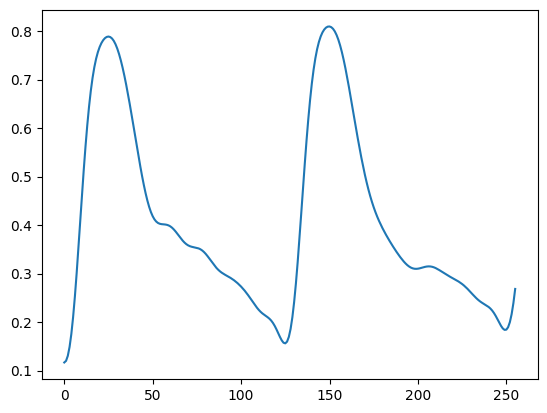

In [ ]:
plt.plot(ppg[9822])

In [ ]:
scales = np.load(r"../data\processed\BP_npy\0625_256_2_clean\p00\scale_train.npy")
gt = sig_npy[0]
out = sig_npy[1]
def calc_min_max(x):
    # x = (x.astype(np.float32)/127.5-1)
    return np.nanmin(x,axis=1),np.nanmax(x,axis=1)
gt[:] -= scales[0,0]
gt[:] /= scales[0,1]
out[:] -= scales[0,0]
out[:] /= scales[0,1]
gt_min,gt_max = calc_min_max(gt)
out_min,out_max = calc_min_max(out)
errors = np.zeros((2,*out_min.shape))
errors[0,:]=gt_min-out_min
errors[1,:]=gt_max-out_max

# get errors (target variable)

In [ ]:
index = pd.read_csv(r"../data/results/ppg_features_small.csv")["signal_index"].values
index

array([   0,    1,    2, ..., 9981, 9982, 9983], dtype=int64)

In [ ]:
errors = errors[:,index]
errors.shape

(2, 6974)

In [ ]:
df = pd.DataFrame(errors.reshape(-1,2),columns=["err_DBP","err_SBP"])
df["abs_err_DBP"] =np.abs(df['err_DBP'])
df["abs_err_SBP"] =np.abs(df['err_SBP'])

In [ ]:
c_DBP = [
    abs(df['abs_err_DBP']) < 5,
    (df['abs_err_DBP'] >= 5) & (df['abs_err_DBP'] < 15),
    df['abs_err_DBP'] >= 15
]
c_SBP = [
    abs(df['abs_err_SBP']) < 5,
    (df['abs_err_SBP'] >= 5) & (df['abs_err_SBP'] < 15),
    df['abs_err_SBP'] >= 15
]
choices = [0, 1, 2]

In [ ]:
df['target_SBP'] = np.select(c_SBP, choices)
df['target_DBP'] = np.select(c_DBP, choices)

In [ ]:
df.head()

,err_DBP,err_SBP,abs_err_DBP,abs_err_SBP,target_SBP,target_DBP
0,-6.893147,-9.505203,6.893147,9.505203,1,1
1,-5.536797,-5.235329,5.536797,5.235329,1,1
2,-18.116745,6.519360,18.116745,6.519360,1,2
3,-36.884052,-19.033958,36.884052,19.033958,2,2
4,-21.217396,-3.074295,21.217396,3.074295,0,2


In [ ]:
df["signal_index"] = index
df

,err_DBP,err_SBP,abs_err_DBP,abs_err_SBP,target_SBP,target_DBP,signal_index
0,-6.893147,-9.505203,6.893147,9.505203,1,1,0
1,-5.536797,-5.235329,5.536797,5.235329,1,1,1
2,-18.116745,6.519360,18.116745,6.519360,1,2,2
3,-36.884052,-19.033958,36.884052,19.033958,2,2,3
4,-21.217396,-3.074295,21.217396,3.074295,0,2,4
...,...,...,...,...,...,...,...
6969,-22.324524,30.808670,22.324524,30.808670,2,2,9979
6970,36.928764,23.052505,36.928764,23.052505,2,2,9980
6971,24.505508,16.756897,24.505508,16.756897,2,2,9981
6972,21.385239,14.779999,21.385239,14.779999,1,2,9982


In [ ]:
df.head ()

,err_DBP,err_SBP,abs_err_DBP,abs_err_SBP,target_SBP,target_DBP,signal_index
0,-6.893147,-9.505203,6.893147,9.505203,1,1,0
1,-5.536797,-5.235329,5.536797,5.235329,1,1,1
2,-18.116745,6.519360,18.116745,6.519360,1,2,2
3,-36.884052,-19.033958,36.884052,19.033958,2,2,3
4,-21.217396,-3.074295,21.217396,3.074295,0,2,4


In [ ]:
df.to_csv("../data/results/target.csv")

In [ ]:
df2 = pd.read_csv(r"../data/results/ppg_features_small.csv",index_col=0)

In [ ]:
df = df.drop(columns=["err_DBP",	"err_SBP",	"abs_err_DBP"	,"abs_err_SBP"	],axis=1)
df3 = pd.merge(df, df2)

In [ ]:
df3.head()

,target_SBP,target_DBP,signal_index,ppg_fft_peaks_0,ppg_fft_peaks_heights_0,ppg_fft_peaks_neighbor_avgs_0,hr_0,p2p_0,ppg_max_neighbor_mean_0,ppg_min_0,...,T_peak_e,T_peak_a_norm,T_peak_b_norm,T_peak_c_norm,T_peak_d_norm,T_peak_e_norm,AI,bd,bcda,sdoo
0,1,1,0,2.0,0.754521,NaN,78.534031,95.5,0.972788,78.0,...,0.104,0.251316,0.130866,-0.052357,0.015680,0.136129,-0.180376,-0.003336,0.143385,0.001699
1,1,1,1,2.0,0.806550,NaN,80.213904,93.5,0.972666,77.0,...,0.100,0.247426,0.134586,-0.059283,0.016021,0.134355,-0.188768,-0.003442,0.172218,0.002079
2,1,2,2,2.0,0.891950,NaN,89.820359,83.5,0.978434,0.0,...,0.104,0.286538,0.139423,-0.045804,0.040122,0.173864,-0.266038,-0.003216,0.080183,0.006862
3,2,2,3,2.0,0.905759,NaN,87.209302,86.0,0.978911,78.0,...,0.116,0.235147,0.105664,-0.017518,0.035037,0.170544,-0.373124,-0.004215,-0.024197,0.006013
4,0,2,4,2.0,0.908642,NaN,86.206897,87.0,0.977175,77.0,...,0.104,0.254412,0.127206,-0.052139,0.023128,0.150334,-0.250745,-0.003838,0.116949,0.003208


In [ ]:
df3.to_csv(r"../data/results/ppg_features_all_small.csv")

# 2

In [ ]:
df["gt_SBP"] = gt_max
df["gt_DBP"] = gt_min

In [ ]:
corr = []
for i in range(len(sig_npy[0])):
    corr.append(np.corrcoef(sig_npy[0,i],sig_npy[2,i])[0,1])

In [ ]:
corr

[0.9444729294170073,
 0.9446229203204158,
 0.9151107794857999,
 0.9541802313327157,
 0.9509273931941998,
 0.9520772936593662,
 0.9475267212302262,
 0.9492015328666747,
 0.9220671704976137,
 0.9635175524287398,
 0.9371902945671653,
 0.9106850272453154,
 0.9262887751137725,
 0.9418695221228539,
 0.9355112892079309,
 0.9217351405374885,
 0.9427794191620805,
 0.9368555053131218,
 0.9429061143776544,
 0.9389749144415758,
 0.9497189146884659,
 0.9523187434554121,
 0.8127292864875794,
 0.9675629720202115,
 0.9641818418661285,
 0.9525430466892387,
 0.9720884890013316,
 0.9053335460999163,
 0.9389073575638326,
 0.905333563882703,
 0.9389073413550437,
 0.9887336686771414,
 0.9834085664484231,
 0.9715363119838196,
 0.9674659647978925,
 0.9507390323736138,
 0.9934353477454009,
 0.9946762420404677,
 0.9892708152238399,
 0.9750889741198272,
 0.9890659292463817,
 0.9618054488802733,
 0.9819253625525156,
 0.9692224491302406,
 0.9744100696656238,
 0.9908090555541958,
 0.9582328723445638,
 0.97659237536

In [ ]:
df["corr"] = corr

In [ ]:
from scipy.stats import *

In [ ]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)


In [ ]:
m = a.mean(axis)
sd = a.std(axis=axis, ddof=ddof)
return np.where(sd == 0, 0, m/sd)

In [ ]:
Nsqi = signaltonoise(sig_npy[2],axis=1)

In [ ]:
Ksqi = kurtosis(sig_npy[2],axis=1)

In [ ]:
Ssqi = skew(sig_npy[2],axis=1)

In [ ]:
df["Nsqi"] = Nsqi
df["Ksqi"] = Ksqi
df["Ssqi"] = Ssqi

In [ ]:
df.head()

,err_DBP,err_SBP,abs_err_DBP,abs_err_SBP,target_SBP,target_DBP,gt_SBP,gt_DBP,corr,Nsqi,Ksqi,Ssqi
0,-6.893147,-9.505203,6.893147,9.505203,1,1,108.433914,58.222172,0.944473,1.853424,-1.248914,0.115490
1,-5.536797,-5.235329,5.536797,5.235329,1,1,108.189690,58.466393,0.944623,1.868523,-1.225156,0.197390
2,-18.116745,6.519360,18.116745,6.519360,1,2,113.660225,66.427979,0.915111,2.295434,-1.221087,0.327870
3,-36.884052,-19.033958,36.884052,19.033958,2,2,108.482758,60.127090,0.954180,1.716473,-1.180554,0.353749
4,-21.217396,-3.074295,21.217396,3.074295,0,2,115.223244,64.669594,0.950927,1.708668,-1.211760,0.315057


In [ ]:
df.to_csv(r"../data/results/stats_features.csv")

In [ ]:
df2=df.loc[:,["target_SBP","target_DBP"]]
df2.head()

,target_SBP,target_DBP
0,1,1
1,1,1
2,1,2
3,2,2
4,0,2


In [ ]:
df2.to_csv(r"../data/results/stats_targets.csv")

## csv にppgとabpを付加

In [ ]:
import pandas as pd
from tqdm import trange
import numpy as np


In [ ]:
ppg.shape

(111600, 1250)

In [6]:
sig = np.load("../data/processed/BP_npy/PulseDB/test.npy")
sig.shape

(111600, 2, 1250)

In [ ]:

for i in trange(11):
    data = pd.read_csv(f"../data/results/ppg_features_pulsedb_test3_{i}.csv")
    print(data.shape)
    data["ppg"] = [sig[idx,1, :] for idx in data["signal_index"].values]  
    data["abp"] =[sig[idx,0, :] for idx in data["signal_index"].values]  
    data.to_parquet(f"../data/processed/parquet/pulsedb_lgbm/ppg_features_pulsedb_test3_{i}.parquet")

  0%|          | 0/11 [00:00<?, ?it/s]

(9465, 100)


  9%|▉         | 1/11 [00:01<00:10,  1.09s/it]

(9863, 100)


 18%|█▊        | 2/11 [00:01<00:08,  1.10it/s]

(9843, 100)


 27%|██▋       | 3/11 [00:02<00:06,  1.15it/s]

(9782, 100)


 36%|███▋      | 4/11 [00:03<00:06,  1.14it/s]

(9669, 100)


 45%|████▌     | 5/11 [00:04<00:05,  1.17it/s]

(9425, 100)


 55%|█████▍    | 6/11 [00:05<00:04,  1.18it/s]

(9130, 100)


 64%|██████▎   | 7/11 [00:06<00:03,  1.15it/s]

(9480, 100)


 73%|███████▎  | 8/11 [00:07<00:02,  1.13it/s]

(9116, 100)


 82%|████████▏ | 9/11 [00:07<00:01,  1.14it/s]

(9421, 100)


 91%|█████████ | 10/11 [00:08<00:00,  1.12it/s]

(9734, 100)


100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


In [ ]:
sig = np.load("../data/processed/BP_npy/PulseDB/train.npy")
sig.shape   

(902160, 2, 1250)

In [ ]:

for i in trange(90):
    data = pd.read_csv(f"../data/results/ppg_features_pulsedb_train_{i}.csv")
    print(data.shape)
    data["ppg"] = [sig[idx,1, :] for idx in data["signal_index"].values]  
    data["abp"] =[sig[idx,0, :] for idx in data["signal_index"].values]  
    data.to_parquet(f"../data/processed/parquet/pulsedb_lgbm/ppg_features_pulsedb_train_{i}.parquet")

  0%|          | 0/90 [00:00<?, ?it/s]

(8052, 100)


  1%|          | 1/90 [00:00<01:11,  1.25it/s]

(7935, 100)


  2%|▏         | 2/90 [00:01<01:07,  1.31it/s]

(7939, 100)


  3%|▎         | 3/90 [00:02<01:06,  1.31it/s]

(7529, 100)


  4%|▍         | 4/90 [00:02<01:00,  1.42it/s]

(7511, 100)


  6%|▌         | 5/90 [00:03<00:57,  1.47it/s]

(7285, 100)


  7%|▋         | 6/90 [00:04<00:54,  1.53it/s]

(8001, 100)


  8%|▊         | 7/90 [00:04<00:54,  1.52it/s]

(7668, 100)


  9%|▉         | 8/90 [00:05<00:53,  1.53it/s]

(7510, 100)


 10%|█         | 9/90 [00:06<00:52,  1.55it/s]

(8020, 100)


 11%|█         | 10/90 [00:06<00:52,  1.52it/s]

(7997, 100)


 12%|█▏        | 11/90 [00:07<00:52,  1.51it/s]

(8180, 100)


 13%|█▎        | 12/90 [00:08<00:53,  1.46it/s]

(7938, 100)


 14%|█▍        | 13/90 [00:08<00:52,  1.48it/s]

(7890, 100)


 16%|█▌        | 14/90 [00:09<00:51,  1.47it/s]

(7337, 100)


 17%|█▋        | 15/90 [00:10<00:50,  1.50it/s]

(7475, 100)


 18%|█▊        | 16/90 [00:10<00:49,  1.51it/s]

(8215, 100)


 19%|█▉        | 17/90 [00:11<00:50,  1.45it/s]

(8221, 100)


 20%|██        | 18/90 [00:12<00:50,  1.44it/s]

(7288, 100)


 21%|██        | 19/90 [00:12<00:48,  1.46it/s]

(7792, 100)


 22%|██▏       | 20/90 [00:13<00:48,  1.45it/s]

(7991, 100)


 23%|██▎       | 21/90 [00:14<00:48,  1.43it/s]

(7447, 100)


 24%|██▍       | 22/90 [00:15<00:47,  1.43it/s]

(7879, 100)


 26%|██▌       | 23/90 [00:15<00:46,  1.43it/s]

(8015, 100)


 27%|██▋       | 24/90 [00:16<00:46,  1.42it/s]

(7976, 100)


 28%|██▊       | 25/90 [00:17<00:46,  1.38it/s]

(7763, 100)


 29%|██▉       | 26/90 [00:17<00:45,  1.40it/s]

(8308, 100)


 30%|███       | 27/90 [00:18<00:45,  1.37it/s]

(8448, 100)


 31%|███       | 28/90 [00:19<00:46,  1.33it/s]

(6663, 100)


 32%|███▏      | 29/90 [00:20<00:43,  1.42it/s]

(7903, 100)


 33%|███▎      | 30/90 [00:20<00:41,  1.44it/s]

(7269, 100)


 34%|███▍      | 31/90 [00:21<00:40,  1.45it/s]

(7943, 100)


 36%|███▌      | 32/90 [00:22<00:39,  1.45it/s]

(7834, 100)


 37%|███▋      | 33/90 [00:22<00:39,  1.44it/s]

(7440, 100)


 38%|███▊      | 34/90 [00:23<00:38,  1.44it/s]

(8165, 100)


 39%|███▉      | 35/90 [00:24<00:38,  1.43it/s]

(7398, 100)


 40%|████      | 36/90 [00:24<00:36,  1.47it/s]

(8298, 100)


 41%|████      | 37/90 [00:25<00:36,  1.43it/s]

(8128, 100)


 42%|████▏     | 38/90 [00:26<00:36,  1.42it/s]

(8205, 100)


 43%|████▎     | 39/90 [00:27<00:36,  1.39it/s]

(8464, 100)


 44%|████▍     | 40/90 [00:27<00:36,  1.37it/s]

(8220, 100)


 46%|████▌     | 41/90 [00:28<00:35,  1.37it/s]

(8077, 100)


 47%|████▋     | 42/90 [00:29<00:34,  1.39it/s]

(8521, 100)


 48%|████▊     | 43/90 [00:30<00:33,  1.39it/s]

(7758, 100)


 49%|████▉     | 44/90 [00:30<00:32,  1.41it/s]

(7729, 100)


 50%|█████     | 45/90 [00:31<00:31,  1.42it/s]

(8340, 100)


 51%|█████     | 46/90 [00:32<00:31,  1.38it/s]

(7886, 100)


 52%|█████▏    | 47/90 [00:32<00:31,  1.39it/s]

(7378, 100)


 53%|█████▎    | 48/90 [00:33<00:29,  1.43it/s]

(8074, 100)


 54%|█████▍    | 49/90 [00:34<00:30,  1.36it/s]

(8507, 100)


 56%|█████▌    | 50/90 [00:35<00:31,  1.28it/s]

(8115, 100)


 57%|█████▋    | 51/90 [00:36<00:30,  1.28it/s]

(8075, 100)


 58%|█████▊    | 52/90 [00:36<00:30,  1.26it/s]

(8246, 100)


 59%|█████▉    | 53/90 [00:37<00:29,  1.24it/s]

(8486, 100)


 60%|██████    | 54/90 [00:38<00:29,  1.21it/s]

(8366, 100)


 61%|██████    | 55/90 [00:39<00:29,  1.20it/s]

(8619, 100)


 62%|██████▏   | 56/90 [00:40<00:28,  1.18it/s]

(8473, 100)


 63%|██████▎   | 57/90 [00:41<00:28,  1.17it/s]

(8445, 100)


 64%|██████▍   | 58/90 [00:41<00:27,  1.18it/s]

(8794, 100)


 66%|██████▌   | 59/90 [00:42<00:26,  1.17it/s]

(7885, 100)


 67%|██████▋   | 60/90 [00:43<00:25,  1.20it/s]

(8414, 100)


 68%|██████▊   | 61/90 [00:44<00:24,  1.19it/s]

(8088, 100)


 69%|██████▉   | 62/90 [00:45<00:23,  1.20it/s]

(8975, 100)


 70%|███████   | 63/90 [00:46<00:23,  1.14it/s]

(8517, 100)


 71%|███████   | 64/90 [00:47<00:23,  1.13it/s]

(8326, 100)


 72%|███████▏  | 65/90 [00:47<00:21,  1.17it/s]

(8866, 100)


 73%|███████▎  | 66/90 [00:48<00:20,  1.17it/s]

(8682, 100)


 74%|███████▍  | 67/90 [00:49<00:19,  1.18it/s]

(8174, 100)


 76%|███████▌  | 68/90 [00:50<00:18,  1.21it/s]

(7778, 100)


 77%|███████▋  | 69/90 [00:51<00:16,  1.24it/s]

(6936, 100)


 78%|███████▊  | 70/90 [00:51<00:15,  1.30it/s]

(8686, 100)


 79%|███████▉  | 71/90 [00:52<00:15,  1.26it/s]

(8356, 100)


 80%|████████  | 72/90 [00:53<00:14,  1.24it/s]

(8203, 100)


 81%|████████  | 73/90 [00:54<00:13,  1.24it/s]

(7951, 100)


 82%|████████▏ | 74/90 [00:55<00:12,  1.25it/s]

(8208, 100)


 83%|████████▎ | 75/90 [00:55<00:12,  1.23it/s]

(9074, 100)


 84%|████████▍ | 76/90 [00:57<00:12,  1.11it/s]

(8656, 100)


 86%|████████▌ | 77/90 [00:57<00:11,  1.12it/s]

(8709, 100)


 87%|████████▋ | 78/90 [00:58<00:10,  1.13it/s]

(8714, 100)


 88%|████████▊ | 79/90 [00:59<00:09,  1.13it/s]

(8697, 100)


 89%|████████▉ | 80/90 [01:00<00:08,  1.12it/s]

(8599, 100)


 90%|█████████ | 81/90 [01:01<00:07,  1.13it/s]

(8991, 100)


 91%|█████████ | 82/90 [01:02<00:07,  1.02it/s]

(8275, 100)


 92%|█████████▏| 83/90 [01:03<00:06,  1.07it/s]

(8518, 100)


 93%|█████████▎| 84/90 [01:04<00:05,  1.10it/s]

(8711, 100)


 94%|█████████▍| 85/90 [01:05<00:04,  1.12it/s]

(8042, 100)


 96%|█████████▌| 86/90 [01:06<00:03,  1.15it/s]

(8298, 100)


 97%|█████████▋| 87/90 [01:06<00:02,  1.16it/s]

(8886, 100)


 98%|█████████▊| 88/90 [01:08<00:01,  1.07it/s]

(8711, 100)


 99%|█████████▉| 89/90 [01:08<00:00,  1.09it/s]

(8453, 100)


100%|██████████| 90/90 [01:09<00:00,  1.29it/s]


In [ ]:
a = pd.read_parquet("../data/processed/parquet/pulsedb_lgbm/ppg_features_pulsedb_test_0.parquet")

In [ ]:
a.head()

,Unnamed: 0,Tc,Ts,Td,Tsteepest,Steepest,TNegSteepest,NegSteepest,TdiaRise,DiaRise,...,T_peak_d_norm,T_peak_e_norm,AI,bd,bcda,sdoo,cycle_zero,signal_index,ppg,abp
0,0,0.762667,0.212000,0.550667,0.131333,0.059188,0.267333,-0.033548,0.431333,0.398171,...,0.082299,0.179931,-0.677468,-0.005723,-0.111338,0.097375,0.118317,0,"[0.2932765855927233, 0.28963062834541314, 0.28...","[0.2318094328025223, 0.2548011995050312, 0.281..."
1,1,0.602667,0.199467,0.403200,0.109867,0.069232,0.282667,-0.036287,0.397333,0.251511,...,0.054070,0.230959,0.052658,-0.006411,0.204059,0.042465,0.012252,1,"[0.7115393313576436, 0.7710721671318311, 0.824...","[0.33407553588730393, 0.33195308293333564, 0.3..."
2,2,0.657714,0.189143,0.468571,0.118286,0.073956,0.241714,-0.056283,0.377143,0.281663,...,0.037264,0.150477,-1.558742,-0.010961,-0.576875,0.067675,0.089054,2,"[0.4409336923802916, 0.5009323340473307, 0.563...","[0.20016315793115544, 0.19949744729101582, 0.2..."
3,3,0.668571,0.181714,0.486857,0.111429,0.071804,0.232571,-0.048818,0.371429,0.316681,...,0.014308,0.137946,0.348570,-0.011465,1.010963,0.024480,0.082243,3,"[0.5417142371831312, 0.5156276152273845, 0.492...","[0.19370186137337664, 0.19445923644000315, 0.1..."
4,4,0.622933,0.172800,0.450133,0.102933,0.076257,0.224533,-0.056560,0.353067,0.311822,...,0.018449,0.156670,0.088379,-0.012316,0.814073,0.038333,0.055659,4,"[0.37640909304247827, 0.36357457539260685, 0.3...","[0.35308797824741533, 0.38640449847697134, 0.4..."


In [ ]:
np.stack(a["ppg"]).shape

(7631, 1250)